##### Copyright 2020 The TensorFlow Authors.

```
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
```

- 참고 : https://www.tensorflow.org/tutorials/generative/autoencoder
- 번역 : 코어닷투데이 http://github.com/coredottoday/DeepLearningTextBook/

# Autoencoders 소개

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/autoencoder">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

이 튜토리얼에서는 3가지 예(기본 사항, 이미지 노이즈 제거 및 이상 감지)를 통해 Autoencoder를 소개합니다.

Autoencoder는 입력을 출력에 복사하도록 훈련된 특수한 유형의 신경망입니다. 예를 들어, 손으로 쓴 숫자의 이미지가 주어지면 Autoencoder는 먼저 이미지를 더 낮은 차원의 잠재 표현으로 인코딩한 다음 잠재 표현을 다시 이미지로 디코딩합니다. Autoencoder는 재구성 오류를 최소화하면서 데이터를 압축하는 방법을 학습합니다.

Autoencoder에 대해 자세히 알아보려면 Ian Goodfellow, Yoshua Bengio 및 Aaron Courville의 딥 러닝에서 14장을 읽어보세요.   
**14장** : https://www.deeplearningbook.org/contents/autoencoders.html

## TensorFlow 및 기타 라이브러리 가져오기

아래 코드는 tensorflow2 를 기준으로 작성되었습니다.   
tensorflow1의 경우 일부 에러나는 내용들은 대체코드를 검색하여 변경해 주세요.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [15]:
tf.__version__

'2.4.1'

각종 warning 메세지를 침묵시키기 위해서 아래의 코드를 실행합니다.

In [11]:
import warnings
import os
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.autograph.set_verbosity(0)

## 데이터셋 로드하기
FashonMNIST 데이터셋을 사용하여 기본 Autoencoder를 훈련해 보겠습니다. 이 데이터셋의 각 이미지는 28x28 픽셀입니다.

In [5]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## 첫 번째 예제 : 기본 오토인코더

![Basic autoencoder results](https://raw.githubusercontent.com/CoreDotToday/DeepLearningTextBook/main/Autoencoder/static/intro_autoencoder_result.png)

두 개의 Dense 레이어로 오토인코더를 정의합니다. 이미지를 64차원 잠재 벡터로 압축하는 `encoder`와 잠재 공간에서 원본 이미지를 재구성하는 `decoder`입니다.

모델을 정의하려면 Keras Model Subclassing API를 사용하세요.[Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [6]:
latent_dim = 64


class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = Autoencoder(latent_dim)

In [7]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

`x_train`을 입력과 대상으로 사용하여 모델을 훈련합니다. `encoder`는 데이터세트를 `784`차원에서 잠재 공간으로 압축하는 방법을 배우고, `decoder`는 원본 이미지를 재구성하는 방법을 배웁니다.

In [12]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0098 - val_loss: 0.0097
Epoch 2/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0095 - val_loss: 0.0095
Epoch 3/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0093 - val_loss: 0.0094
Epoch 4/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 5/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 7/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 8/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 9/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 10/10
1875/1875 [==============================] - 22s 12m

모델이 훈련되었으므로 테스트셋에서 이미지를 인코딩 및 디코딩하여 테스트해 보겠습니다.

In [16]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

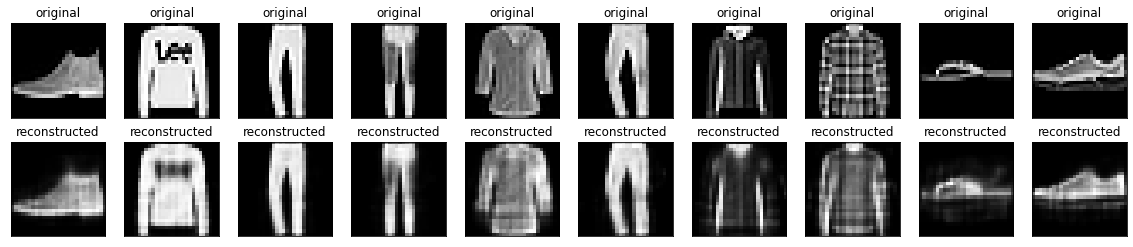

In [17]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 두 번째 예제 : 이미지 노이즈 제거

![Image denoising results](https://raw.githubusercontent.com/CoreDotToday/DeepLearningTextBook/main/Autoencoder/static/image_denoise_fmnist_results.png)

오토인코더는 이미지에서 노이즈를 제거하도록 훈련될 수도 있습니다.   

이번 예제는 각 이미지에 임의의 노이즈를 적용하여 Fashion MNIST 데이터셋의 노이즈 버전을 생성합니다. 그런 다음 노이즈가 있는 이미지를 입력으로 사용하고 원본 이미지를 대상으로 사용하여 오토인코더를 훈련합니다.

이전에 수정한 내용을 덮어쓰기 위해 데이터셋을 다시 가져오겠습니다.

In [19]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [20]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


이미지에 임의의 노이즈를 추가합니다.

In [21]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

노이즈가 있는 이미지를 플롯합니다.

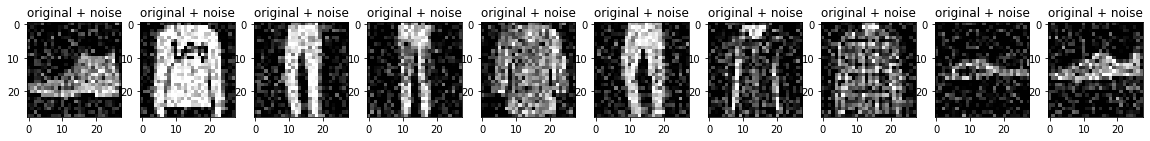

In [22]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

원본 이미지에 지글지글하게 노이즈가 추가된 것이 보이시지요?   
이제 이 노이즈를 제거하는 오토인코더를 학습시켜 보겠습니다.

### 컨볼루셔널 오토인코더 정의하기

이 예제에서는 `encoder`에 [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) 레이어를 사용하고 `decoder`에 [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) 레이어를 사용하여 컨볼루셔널 autoencoder를 훈련합니다.

이쁘게 클래스로 묶어서 만들어 보겠습니다.

In [24]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        # 인코더를 정의합니다
        self.encoder = tf.keras.Sequential(
            [
                layers.Input(shape=(28, 28, 1)),
                layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
                layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)
            ]
        )

        # 디코더를 정의합니다
        self.decoder = tf.keras.Sequential(
            [
                layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
                layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
                layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
            ]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = Denoise()

In [25]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [26]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,  # 훈련할 데이터를 섞어(shuffle) 줍니다
                validation_data=(x_test_noisy, x_test)
               )

Epoch 1/10
1875/1875 [==============================] - 57s 28ms/step - loss: 0.0366 - val_loss: 0.0101
Epoch 2/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0098 - val_loss: 0.0091
Epoch 3/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 4/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 5/10
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 6/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 7/10
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 8/10
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 9/10
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 10/10
1875/1875 [==============================] - 53s 28m

`encoder` 모델을 살펴보겠습니다. 이미지가 28x28에서 7x7로 어떻게 다운샘플링되는지 shape 부분을 통해 확인하세요.

In [28]:
autoencoder.encoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


`decoder`는 이미지를 7x7에서 28x28로 다시 업샘플링합니다.

In [29]:
autoencoder.decoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


autoencoder에서 생성된 `노이즈가 있는 이미지`와 `노이즈가 제거된 이미지`를 모두 그려보겠습니다.

In [30]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

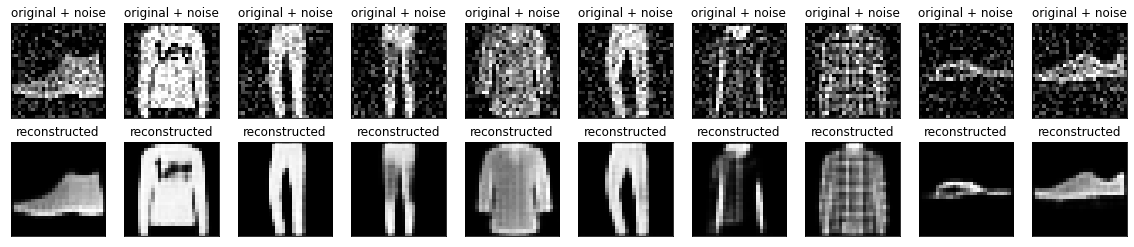

In [31]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## 세 번째 예제 : 이상 감지 (Anomaly detection)

이번에는 [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000)에서 이상을 감지하도록 autoencoder를 훈련합니다. 이 데이터세트에는 각각 140개의 데이터 포인트가 있는 5,000개의 심전도([Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography))가 포함되어 있습니다. 단순화된 버전의 데이터세트를 사용하고, 각 예제는 0(비정상 리듬에 해당) 또는 1(정상 리듬에 해당)로 레이블이 지정됩니다. 여러분은 비정상 리듬을 식별하는 것을 목표로 합니다.

참고: 레이블이 지정된 데이터세트를 사용하므로 지도 학습 문제라고 표현할 수 있습니다. 이 예제의 목표는 사용 가능한 레이블이 없는 더 큰 데이터세트에 적용할 수 있는 이상 감지 개념을 설명하는 것입니다 (예: 정상 리듬이 수천 개이고 비정상 리듬이 적은 경우).

autoencoder를 사용하여 이상을 어떻게 감지하시겠습니까? autoencoder는 재구성 오류를 최소화하도록 훈련되었습니다. autoencoder는 정상 리듬으로만 훈련한 다음 이 autoencoder를 사용하여 모든 데이터를 재구성합니다. 여기서 가설은 비정상 리듬의 경우에 재구성 오류가 더 클 것이라는 것입니다. 그런 다음 재구성 오류가 고정 임계값을 초과하는 경우, 리듬을 이상으로 분류합니다.

### ECG 데이터 로드하기

사용할 데이터셋은 [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000)에서 제공하는 ECG5000 입니다.

In [32]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [36]:
# 마지막 열의 값이 레이블 값 입니다.
labels = raw_data[:, -1]

In [37]:
labels

array([1., 1., 1., ..., 0., 0., 0.])

In [40]:
# 레이블을 제외한 나머지 데이터를 선택합니다.
data = raw_data[:, 0:-1]

In [41]:
data

array([[-0.11252183, -2.8272038 , -3.7738969 , ...,  0.12343082,
         0.92528624,  0.19313742],
       [-1.1008778 , -3.9968398 , -4.2858426 , ...,  0.77381971,
         1.1196209 , -1.4362499 ],
       [-0.56708802, -2.5934502 , -3.8742297 , ...,  0.32109663,
         0.90422673, -0.42179659],
       ...,
       [-1.1229693 , -2.2529248 , -2.8676281 , ..., -2.874136  ,
        -2.0083694 , -1.8083338 ],
       [-0.54770461, -1.8895451 , -2.8397786 , ...,  1.261335  ,
         1.1504486 ,  0.80493225],
       [-1.3517791 , -2.2090058 , -2.5202247 , ..., -2.2600228 ,
        -1.577823  , -0.68453092]])

이제 train과 test로 구분해서 사용하겠습니다.

In [42]:
train_data, test_data, train_labels, test_labels = train_test_split(
                                                                    data, labels, test_size=0.2, random_state=21
                                                                    )

데이터를 `[0,1]`로 정규화합니다.

In [43]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

이 데이터세트에서 `1`로 레이블이 지정된 정상 리듬만 사용하여 autoencoder를 훈련합니다. 정상 리듬과 비정상 리듬을 분리합니다.

In [44]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

정상적인 ECG를 플롯합니다.

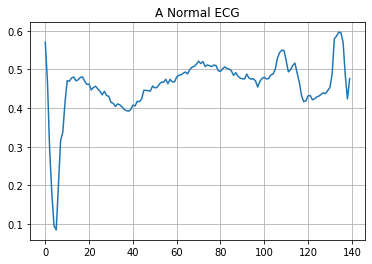

In [45]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

비정상적인 ECG를 플롯합니다.

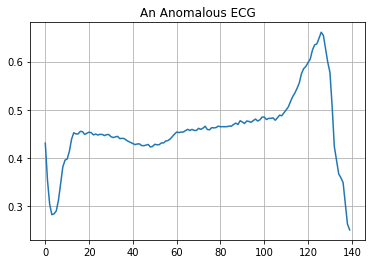

In [46]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### 모델 빌드하기

In [47]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(140, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = AnomalyDetector()

In [48]:
autoencoder.compile(optimizer='adam', loss='mae')

autoencoder는 일반 ECG만 사용하여 훈련되지만, 전체 테스트세트를 사용하여 평가됩니다.

In [49]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 2s 182ms/step - loss: 0.0586 - val_loss: 0.0534
Epoch 2/20
5/5 [==============================] - 0s 41ms/step - loss: 0.0565 - val_loss: 0.0520
Epoch 3/20
5/5 [==============================] - 0s 41ms/step - loss: 0.0543 - val_loss: 0.0504
Epoch 4/20
5/5 [==============================] - 0s 39ms/step - loss: 0.0514 - val_loss: 0.0490
Epoch 5/20
5/5 [==============================] - 0s 40ms/step - loss: 0.0482 - val_loss: 0.0469
Epoch 6/20
5/5 [==============================] - 0s 39ms/step - loss: 0.0446 - val_loss: 0.0451
Epoch 7/20
5/5 [==============================] - 0s 42ms/step - loss: 0.0414 - val_loss: 0.0436
Epoch 8/20
5/5 [==============================] - 0s 40ms/step - loss: 0.0386 - val_loss: 0.0422
Epoch 9/20
5/5 [==============================] - 0s 42ms/step - loss: 0.0363 - val_loss: 0.0412
Epoch 10/20
5/5 [==============================] - 0s 40ms/step - loss: 0.0340 - val_loss: 0.0402
Epoch 11/20
5/5 [===========

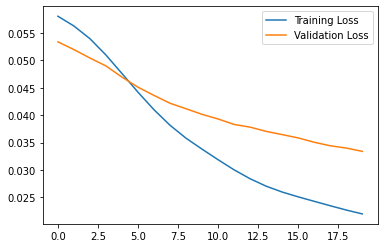

In [50]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

재구성 오류가 정상 훈련 예제에서 하나의 표준 편차보다 큰 경우, ECG를 비정상으로 분류합니다.   
먼저, 훈련 세트의 정상 ECG, autoencoder에 의해 인코딩 및 디코딩된 후의 재구성 값과 재구성 오류를 플롯해 보겠습니다.

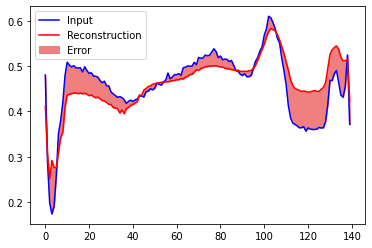

In [51]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

이번에는 비정상적인 테스트 예제에서 비슷한 플롯을 만듭니다.

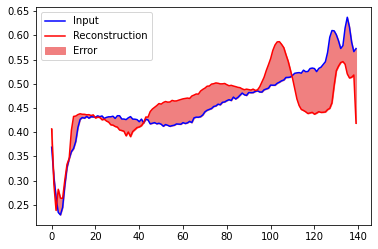

In [52]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### 이상 감지하기

재구성 손실이 고정 임계값보다 큰지 여부를 계산하여 이상을 감지합니다.   
이 튜토리얼에서는 훈련 셋에서 정상 예제에 대한 평균 오차를 계산한 다음, 재구성 오류가 훈련 셋의 표준 편차보다 큰 경우 향후 예제를 비정상적인 것으로 분류합니다.

훈련 셋에서 정상 ECG에 대한 재구성 오류를 플롯합니다.

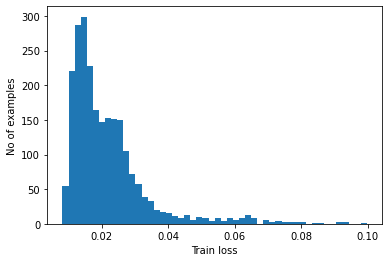

In [53]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

평균(mean)보다 표준 편차(standard deviations)가 높은 임계값(threshold)을 선택합니다.

In [57]:
np.mean(train_loss)

0.021622267

In [58]:
np.std(train_loss)

0.012003175

In [54]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.033625443


참고 : 왜 이렇게 임계값을 선택하는지 의문을 가지실 수 있습니다. 임계값을 선택하는 데 사용할 수 있는 전략은 여러 가지가 있습니다. 올바른 접근 방식은 데이터셋에 따라 다릅니다. 이 튜토리얼의 끝에 있는 링크를 참고해 주세요.

테스트 셋에서 비정상적인 예제에 대한 재구성 오류를 조사하면 대부분 임계값보다 더 큰 재구성 오류가 있음을 알 수 있습니다. 임계값을 변경하여 분류자의 정밀도([precision](https://developers.google.com/machine-learning/glossary#precision))와 재현율([recall](https://developers.google.com/machine-learning/glossary#recall))을 조정할 수 있습니다.

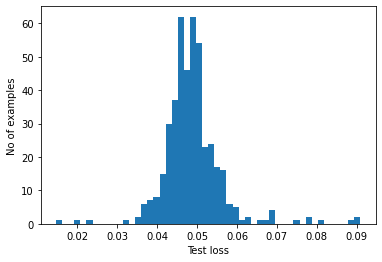

In [59]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

재구성 오류가 임계값보다 큰 경우 ECG를 이상으로 분류합니다.

In [60]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)


def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [61]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.942
Precision = 0.9921568627450981
Recall = 0.9035714285714286


## Next steps

autoencoder를 사용한 이상 탐지에 대해 자세히 알아보려면 Victor Dibia가 TensorFlow.js로 빌드한 훌륭한 인터랙티브 예제([interactive example](https://anomagram.fastforwardlabs.com/#/))를 확인하세요.   
실제 사용 사례의 경우, TensorFlow를 사용하여 [Airbus가 ISS 원격 측정 데이터에서 이상을 감지하는 방법](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html)을 알아볼 수 있습니다.   

기본 사항에 대해 자세히 알아보려면 François Chollet의 [블로그 게시물](https://blog.keras.io/building-autoencoders-in-keras.html)을 읽어보세요.   
자세한 내용은 Ian Goodfellow, Yoshua Bengio, Aaron Courville의 딥 러닝에서 [14장](https://www.deeplearningbook.org/contents/autoencoders.html)을 확인하세요.